100%|██████████| 9.91M/9.91M [00:01<00:00, 4.97MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 126kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.2MB/s]


Epoch #1


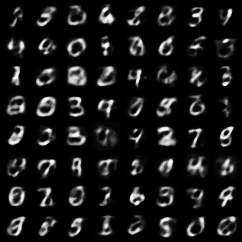



Epoch #2


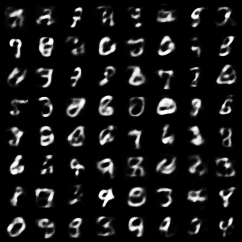



Epoch #3


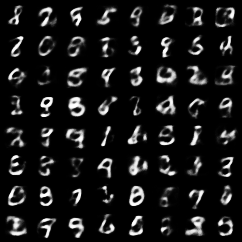



Epoch #4


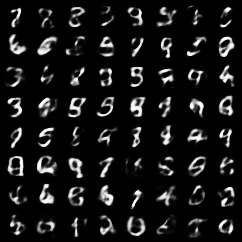



Epoch #5


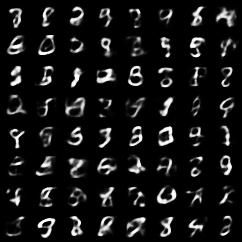



Epoch #6


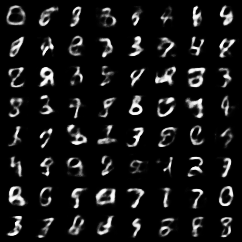



Epoch #7


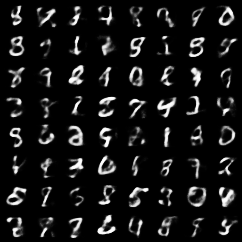



Epoch #8


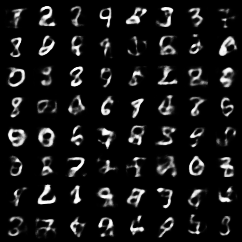



Epoch #9


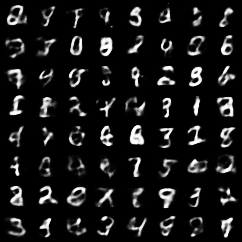



Epoch #10


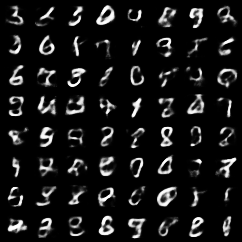



Epoch #11


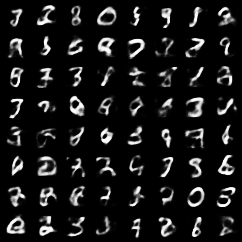



Epoch #12


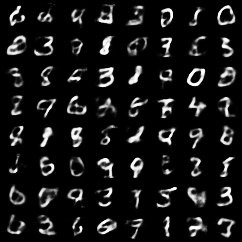



Epoch #13


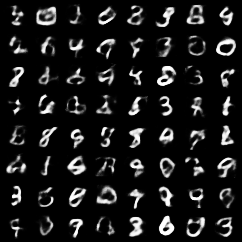



Epoch #14


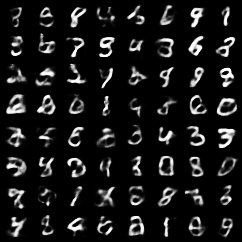



Epoch #15


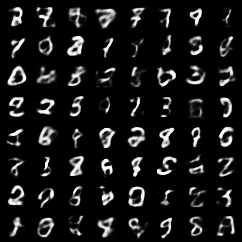



Epoch #16


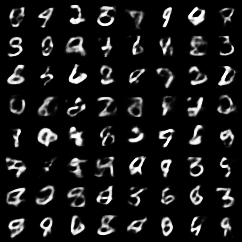



Epoch #17


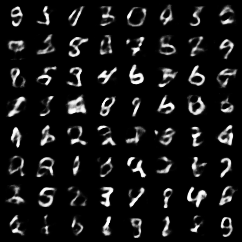



Epoch #18


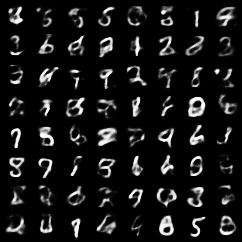



Epoch #19


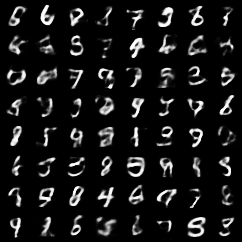



Epoch #20


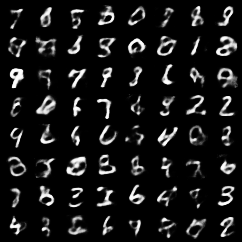



Epoch #21


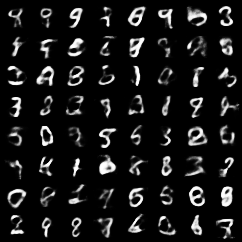



Epoch #22


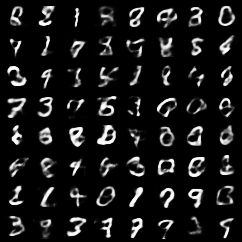



Epoch #23


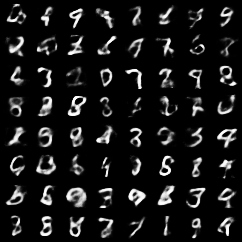



Epoch #24


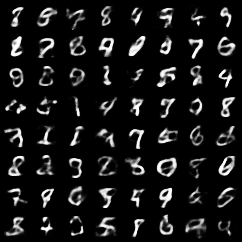



Epoch #25


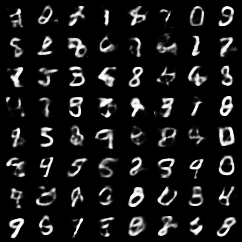



Epoch #26


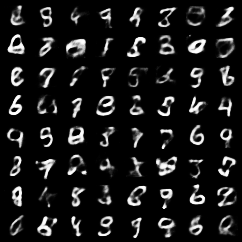



Epoch #27


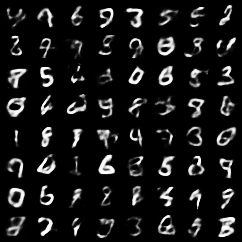



Epoch #28


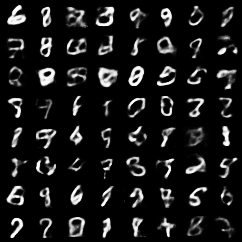



Epoch #29


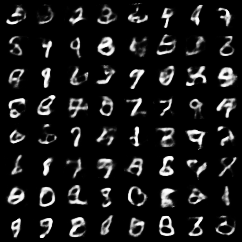



Epoch #30


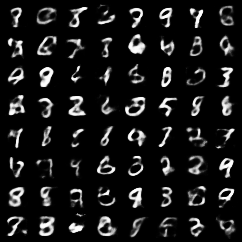



Epoch #31


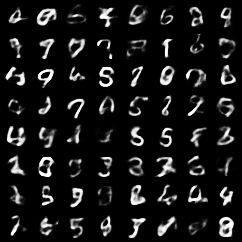



Epoch #32


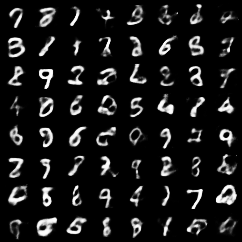



Epoch #33


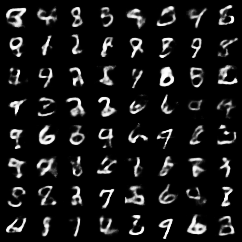



Epoch #34


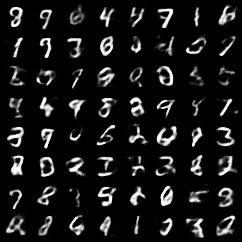



Epoch #35


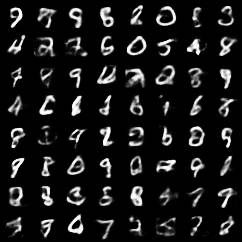



Epoch #36


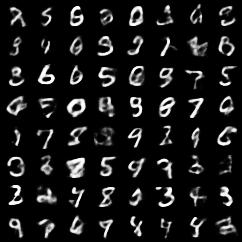



Epoch #37


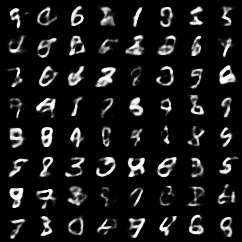



Epoch #38


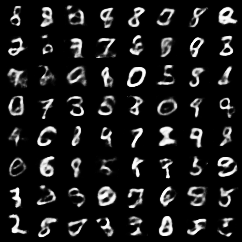



Epoch #39


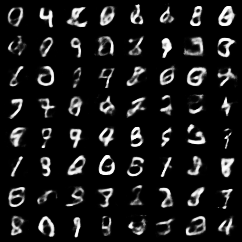



Epoch #40


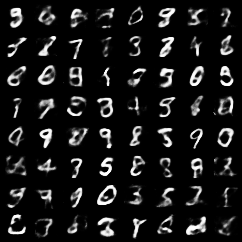



Epoch #41


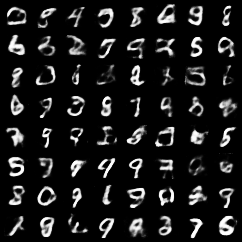



Epoch #42


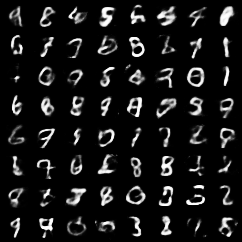



Epoch #43


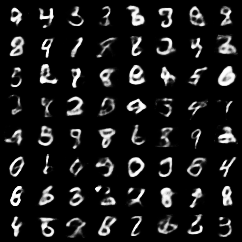



Epoch #44


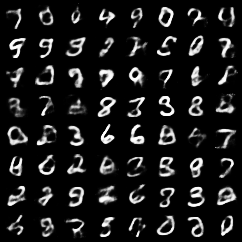



Epoch #45


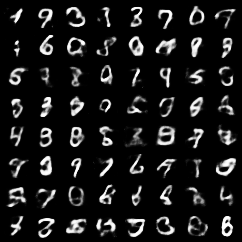



Epoch #46


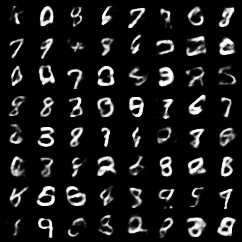



Epoch #47


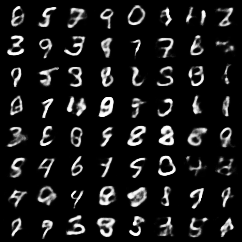



Epoch #48


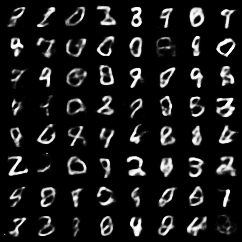



Epoch #49


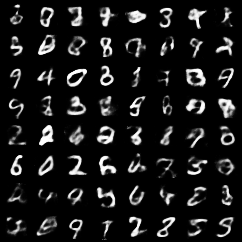



Epoch #50


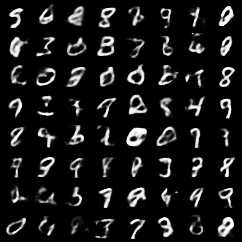

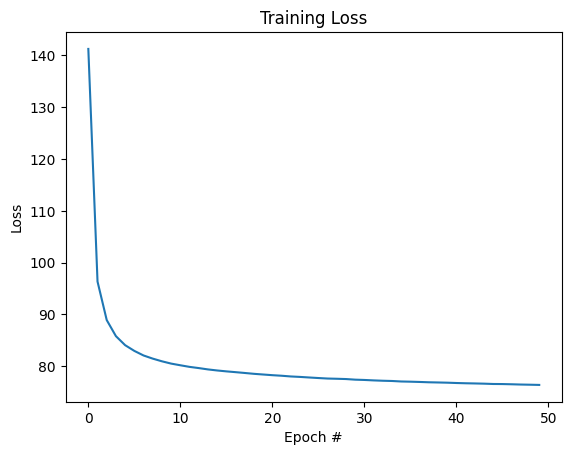

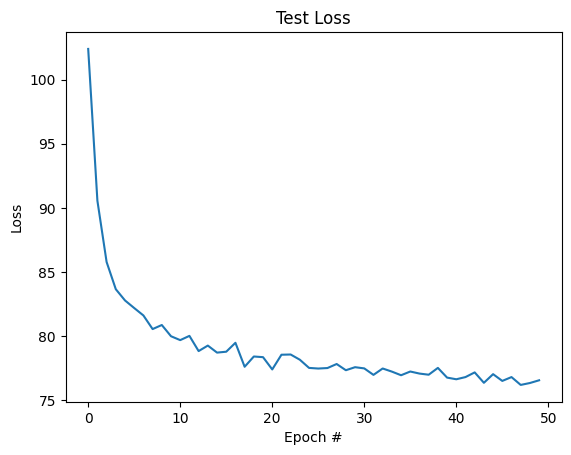

In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from IPython.display import Image, display
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F

if not os.path.exists('results'):
    os.mkdir('results')

batch_size = 100
latent_size = 20

cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
# load image data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)


class VAE(nn.Module):
    # basic VAE architecture
    def __init__(self):
        super(VAE, self).__init__()
        # encoder layers
        self.fc1 = nn.Linear(784, 400)
        self.fc_mu = nn.Linear(400, latent_size)
        self.fc_logvar = nn.Linear(400, latent_size)
        # decoder layers
        self.fc_dec1 = nn.Linear(latent_size, 400)
        self.fc_dec2 = nn.Linear(400, 784)

    def encode(self, x):
        # encoder forward pass
        x = x.view(-1, 784)
        hidden = F.relu(self.fc1(x))
        means = self.fc_mu(hidden)
        log_variances = self.fc_logvar(hidden)
        return means, log_variances

    def reparameterize(self, means, log_variances):
                # takes in the coordinatewise means and log-variances from the encoder (each of dimension latent_size), and returns a sample from a Gaussian with the corresponding parameters
        std = torch.exp(0.5 * log_variances)
        eps = torch.randn_like(std)
        return means + eps * std

    def decode(self, z):
        # decoder forward pass
        # takes an input of size latent_size and produces an output of size 784
        hidden = F.relu(self.fc_dec1(z))
        reconstructed_x = torch.sigmoid(self.fc_dec2(hidden))
        return reconstructed_x

    def forward(self, x):
        # forward pass through the entire VAE architecture
        # Returns an output image of size 784, as well as the means and log_variances
        means, log_variances = self.encode(x)
        z = self.reparameterize(means, log_variances)
        reconstructed_x = self.decode(z)
        return reconstructed_x, means, log_variances


def vae_loss_function(reconstructed_x, x, means, log_variances):
    # Compute the VAE loss
    # loss = reconstruction error + KL divergence
    # Use cross entropy loss between x and reconstructed_x for the reconstruction error
    # Returns loss (reconstruction + KL divergence) and reconstruction loss only
    x = x.view(-1, 784)
    reconstruction_loss = F.binary_cross_entropy(reconstructed_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_variances - means.pow(2) - log_variances.exp())
    loss = reconstruction_loss + kl_divergence
    return loss, reconstruction_loss


def train(model, optimizer):
    # Trains the VAE for one epoch on the training dataset
    # Returns the average (over the dataset) loss (reconstruction + KL divergence) and reconstruction loss only
    model.train()
    total_loss = 0.0
    total_reconstruction_loss = 0.0

    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        reconstructed_batch, means, log_variances = model(data)
        loss, reconstruction_loss = vae_loss_function(reconstructed_batch, data, means, log_variances)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_reconstruction_loss += reconstruction_loss.item()

    avg_train_loss = total_loss / len(train_loader.dataset)
    avg_train_reconstruction_loss = total_reconstruction_loss / len(train_loader.dataset)
    return avg_train_loss, avg_train_reconstruction_loss


def test(model):
    # Runs the VAE on the test dataset
    # Returns the average (over the dataset) loss (reconstruction + KL divergence) and reconstruction loss only
    model.eval()
    total_loss = 0.0
    total_reconstruction_loss = 0.0

    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            reconstructed_batch, means, log_variances = model(data)
            loss, reconstruction_loss = vae_loss_function(reconstructed_batch, data, means, log_variances)

            total_loss += loss.item()
            total_reconstruction_loss += reconstruction_loss.item()

    avg_test_loss = total_loss / len(test_loader.dataset)
    avg_test_reconstruction_loss = total_reconstruction_loss / len(test_loader.dataset)
    return avg_test_loss, avg_test_reconstruction_loss


epochs = 50
avg_train_losses = []
avg_train_reconstruction_losses = []
avg_test_losses = []
avg_test_reconstruction_losses = []

vae_model = VAE().to(device)
vae_optimizer = optim.Adam(vae_model.parameters(), lr=1e-3)

for epoch in range(1, epochs + 1):
    avg_train_loss, avg_train_reconstruction_loss = train(vae_model, vae_optimizer)
    avg_test_loss, avg_test_reconstruction_loss = test(vae_model)

    avg_train_losses.append(avg_train_loss)
    avg_train_reconstruction_losses.append(avg_train_reconstruction_loss)
    avg_test_losses.append(avg_test_loss)
    avg_test_reconstruction_losses.append(avg_test_reconstruction_loss)

    with torch.no_grad():
        sample = torch.randn(64, latent_size).to(device)
        sample = vae_model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')
        print('Epoch #' + str(epoch))
        display(Image('results/sample_' + str(epoch) + '.png'))
        print('\n')

plt.plot(avg_train_reconstruction_losses)
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch #')
plt.show()

plt.plot(avg_test_reconstruction_losses)
plt.title('Test Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch #')
plt.show()